In [2]:
!pip install qutip
!pip install krotov
!pip install watermark

In [3]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import sys
import os
import qutip
from qutip import *
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d
%watermark -v --iversions

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 8.16.1

krotov    : 1.2.1
matplotlib: 3.8.0
qutip     : 4.7.5
scipy     : 1.11.3
numpy     : 1.26.4
sys       : 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:36:57) [Clang 15.0.7 ]



In [4]:
N = 16# dimension of the fock space
# cavity operators
alpha = 1
a = tensor(destroy(N), qeye(2),qeye(2))# N, tau, sigma
nc = a.dag() * a # photon number
p = (qeye(2) + sigmaz())/2
m = (qeye(2) - sigmaz())/2
spin_minus  = tensor(qeye(N), p ,destroy(2))
spin_plus = tensor(qeye(N), m ,sigmam())
nq = spin_minus.dag() * spin_minus # qubit number
nq2 = spin_plus.dag() * spin_plus # qubit number
xc = a + a.dag()

#orbital operators
tau_z = tensor(qeye(N), sigmaz(), qeye(2))
tau_x = tensor(qeye(N), sigmax(), qeye(2))
sigma_z = tensor(qeye(N), qeye(2), sigmaz())
sigma_x = tensor(qeye(N), qeye(2), sigmax())

x0 = tau_x
z0 = tau_z
_0z = sigma_z
zx = tensor(qeye(N), sigmaz(), sigmax())
xx = tensor(qeye(N), sigmax(), sigmax())
yy = tensor(qeye(N), sigmay(), sigmay())
zz = tensor(qeye(N), sigmaz(), sigmaz())
zy = tensor(qeye(N), sigmaz(), sigmay())
pm = tensor(qeye(N), sigmap(), sigmam())
mp = tensor(qeye(N), sigmam(), sigmap())
pp = tensor(qeye(N), sigmap(), sigmap())
mm = tensor(qeye(N), sigmam(), sigmam())
#tensor for S-W transformation
y0 = tensor(qeye(N), sigmay(), qeye(2))
Id = tensor(qeye(N), qeye(2), qeye(2))

# plot color
colors = ['#8000ff', '#2b7ff6', '#2adddd', '#80ffb4', '#d4dd80', '#ff8042', '#ff0000']
#['blue', 'orange', 'green', 'red',  'cyan', 'purple', 'pink', 'gray', 'olive','brown']


In [5]:

gamma = 0.01 * 2 * np.pi # relaxation rate
kappa = 0.005 * 2 * np.pi # cavity loss rate


def H_sys(t,epsilon):
    wr = 1 * 2 * np.pi  # resonator frequency
    bx =  0.22* 2 * np.pi
    Bz =125 *  bx  # z-component of the magnetic field
    g = 0.05 * 2 * np.pi  # coupling strength

    theta = np.arctan(epsilon/t) # molecular mixing angle
    Bx = bx * np.sin(theta)# x-component of the magnetic field
    Omega = np.sqrt(epsilon**2 + t**2) # Energy gap

    phi = np.pi - np.arctan(Bx/Bz) # Energy gap angle
    phi_plus =np.arctan(bx*np.cos(theta)/(Omega + np.sqrt(Bx**2 + Bz**2)))
    magnitude_B = np.sqrt(Bx**2 + Bz**2)
    if Omega > magnitude_B:
        phi_minus = np.arctan(bx * np.cos(theta) / (Omega - magnitude_B))
    elif Omega < magnitude_B:
        phi_minus = np.pi + np.arctan(bx * np.cos(theta) / (Omega - magnitude_B))
    else:
        # Handle the case where Omega equals magnitude_B if necessary
        phi_minus = None  # or some default value

    #phi_minus = np.pi+ np.arctan(bx*np.cos(theta)/( Omega - np.sqrt(Bx**2 + Bz**2)))
    phi_bar  = (phi_plus + phi_minus)/2
    delta_phi = (phi_plus - phi_minus)/2

    Em = bx * np.cos(theta) *(1/np.cos(phi_plus) + 1/np.cos(phi_minus))/2
    Es = bx * np.cos(theta) *(1/np.cos(phi_plus) - 1/np.cos(phi_minus))/2
    E_plus = Em + Es
    E_minus = Em - Es
    Emp = 0
    Esp = 0

    d_x0 = -np.cos(theta) * np.cos(phi) * np.cos(phi_bar)
    d_zx = np.cos(theta) * np.cos(phi) * np.sin(phi_bar)
    d_xx = np.sin(theta) * np.sin(phi_bar) * np.cos(delta_phi) + np.cos(theta) * np.sin(phi) * np.sin(phi_bar) * np.sin(delta_phi)
    d_yy = -np.sin(theta) * np.cos(phi_bar) * np.sin(delta_phi) + np.cos(theta) * np.sin(phi) * np.cos(phi_bar) * np.cos(delta_phi)
    d_z0 = np.sin(theta) * np.cos(phi_bar) * np.cos(delta_phi) + np.cos(theta) * np.sin(phi) * np.cos(phi_bar) * np.sin(delta_phi)
    d_0z = -np.sin(theta) * np.sin(phi_bar) * np.sin(delta_phi) + np.cos(theta) * np.sin(phi) * np.sin(phi_bar) * np.cos(delta_phi)

    # effective coupling strength
    gm = -g *d_x0
    gs = g *d_zx
    g_plus = g*(d_xx - d_yy)
    g_minus = g*(d_xx + d_yy)
    gmp  = g*d_z0
    gsp = g*d_0z

    # dispersive shift
    chi_s = (2 * Es * gs**2) / (wr**2 - Es**2) + (E_plus * g_plus**2) / (wr**2 - E_plus**2) - (E_minus * g_minus**2) / (wr**2 - E_minus**2)
    chi_m = (2 * Em * gm**2) / (wr**2 - Em**2) + (E_plus * g_plus**2) / (wr**2 - E_plus**2) + (E_minus * g_minus**2) / (wr**2 - E_minus**2)
    chi_0 = (2*wr * gmp*gsp) / (wr**2 - Esp**2)  + (2*wr * gmp*gsp) / (wr**2 - Emp**2)\
        + (wr * g_plus**2) / (wr**2 - E_plus**2) - (wr * g_minus**2) / (wr**2 - E_minus**2)
    tau = np.pi/chi_s  # pi pulse
    delta = abs(wr - Es)  # detuning

    #renormalized parameters
    wr_prime = wr + chi_m
    chi = chi_s
    wq = Es + chi_0 - chi_s

    #S-W coefficients
    eta_m = (2 * Em * gm) / (wr**2 - Em**2)
    eta_s = (2 * Es * gs) / (wr**2 - Es**2)
    eta_plus = (2*E_plus * g_plus) / (wr**2 - E_plus**2)
    eta_minus = (2*E_minus * g_minus) / (wr**2 - E_minus**2)
    eta_prime_m = (2 * wr * gm) / (wr**2 - Em**2)
    eta_prime_s = (2 * wr * gs) / (wr**2 - Es**2)
    eta_prime_plus = (2*wr * g_plus) / (wr**2 - E_plus**2)
    eta_prime_minus = (2*wr * g_minus) / (wr**2 - E_minus**2)
    eta_prime_mp = (2*wr * gmp) / (wr**2 - Emp**2)
    eta_prime_sp = (2*wr * gsp) / (wr**2 - Esp**2)

    wq = Es + chi_0 - chi_s
    #S-W transformation  matrix
    S = (a.dag()+ a )/2 *\
        (1j * eta_m * y0 - 1j * eta_s * zy - eta_plus * (pp - mm) -  eta_minus * (pm - mp)) \
        -1j * (a - a.dag())/2 *\
            (1j * eta_prime_m * x0 -1j * eta_prime_s * zx -1j * eta_prime_plus * (pp + mm) -1j * eta_prime_minus * (pm + mp) - 1j * eta_prime_mp  * z0 - 1j * eta_prime_sp * _0z )

    S_reduced00 = (a.dag()+ a )/2* (  -1j * eta_s * zy ) \
        + ( a.dag()-a )/2 * (  eta_prime_s * zx  )
    S_reduced=a.dag()/2*(-1j * eta_s * zy+ eta_prime_s * zx) \
            + a/2*(-1j * eta_s * zy- eta_prime_s * zx)

    commut_diag_1 = - eta_prime_s * gs * Id
    commut_diag_2 = -2*eta_s * gs * sigma_z * (a.dag()*a+0.5)
    commut_trans_3 = - eta_s * gs * sigma_z * (a.dag()*a.dag() + a*a)
    H_tr= ( commut_trans_3)/2
    # Hamiltonian
    H_non_int = Es/2 * sigma_z + Em/2 * tau_z
    H_int_1 = (a+a.dag() )* (-gm *x0 +(gs * zx)+\
        g_plus * (pp + mm) + g_minus * (pm + mp) +\
            gmp * z0 + gsp * _0z)
    H_int_3 = -0.5*chi_0*zz - (chi_m*tau_z + chi_s*sigma_z)*(a.dag()*a+0.5)
    H0_1 = H_non_int + H_int_1 - H_tr
    commutator_1 = commutator(S_reduced, H_int_1)
    commutator_2 = commutator(S_reduced,commutator_1)
    commutator_3 = commutator(S_reduced,commutator_2)
    commutator_4 = commutator(S_reduced,commutator_3)
    commutator_5 = commutator(S_reduced,commutator_4)
    H0_2 = H_non_int+ 1/2*commutator_1 #+1/3*commutator_2 + 1/8*commutator_3 + 1/30*commutator_4 + 1/144*commutator_5
    #0.5*commutator(S_reduced, H_int_1)+1/3*commutator(S_reduced,commutator(S_reduced, H_int_1))*0+1/8*commutator(S_reduced,commutator(S_reduced,commutator(S_reduced, H_int_1)))#(commut_diag_1+commut_diag_2+commut_trans_3)/2
    H0_1_sw = (-S).expm()*H0_1*(S).expm()
    H0_3 = H_non_int + H_int_3

    return H0_3,chi,wq,wr
H0,chi,wq,wr = H_sys(t= 0.008*5.9 * 2 * np.pi,epsilon = 0)

In [6]:
def hamiltonian(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """

    H0,chi,wq,wr = H_sys(t= 0.008*5.9 * 2 * np.pi,epsilon = 0)
    #H0 = wr * a.dag() * a + Ez/2 * Sigmaz - chi * Sigmaz * (a.dag() * a + 0.5 )
    H1 = a + a.dag()
    H2 = -1j*(a - a.dag() )
    H3 = sigma_x

    def AnalyticContorl(t, args):
        return  chi*np.cos(wq * t)

    def guess_control1(t, args):
        return 0*krotov.shapes.box(
            t, t_start=0, t_stop=1
        )
    def guess_control2(t, args):
        return  0*krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )
    def guess_control3(t, args):
        return  krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )
    return [H0, [H1, guess_control1], [H2, guess_control2], [H3,AnalyticContorl]]


In [7]:
H = hamiltonian()

target4 = tensor(fock(N, 0), basis(2, 0), basis(2, 0))
#(tensor(coherent(N,alpha*2j), basis(2, 0), basis(2, 0))+ tensor(coherent(N,0), basis(2, 0), 1*basis(2, 1))).unit()
target5 = tensor((coherent(N,0)+1j*coherent(N,-2*alpha*1j)).unit(), basis(2, 0), basis(2, 0))
initialState = target4 #(tensor(fock(N, 1), basis(2, 0), basis(2, 0)) + tensor(fock(N, 0), basis(2, 0), basis(2, 0))).unit()
targetState = target5 #(tensor(fock(N,1 ), basis(2, 0), basis(2, 0)) + tensor(fock(N,0 ), basis(2, 0), basis(2, 1))).unit()

In [8]:
t_stop = 1000
tlist = np.linspace(0, t_stop, 50000)

In [9]:
1/0.007

142.85714285714286

In [10]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

In [11]:
objectives = [
    krotov.Objective(
        initial_state=initialState, target=targetState, H=H
    )
]

In [12]:

def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0., t_stop=t_stop , t_rise=0.5, func='sinsq'
    )

In [13]:
pulse_options = {
    H[1][1]: dict(lambda_a=0.5, update_shape=S),
    H[2][1]: dict(lambda_a=0.5, update_shape=S),
    H[3][1]: dict(lambda_a=0.5, update_shape=S),
}



In [14]:
proj0 = tensor(qeye(N), ket2dm(ket("0")))
proj1 = tensor(qeye(N), ket2dm(ket("1")))


In [15]:
guess_dynamics = objectives[0].mesolve(rho0 =target4,tlist=tlist, e_ops=[nc, nq])

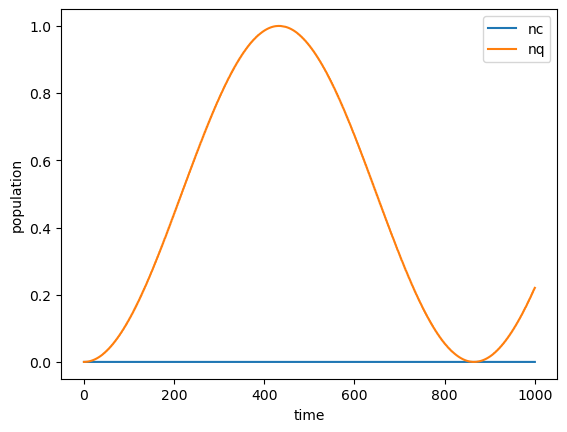

In [16]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='nc')
    ax.plot(result.times, result.expect[1], label='nq')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)
plot_population(guess_dynamics)

In [17]:

resultState = objectives[0].mesolve(rho0 =target4,tlist=tlist).states[-1]


In [18]:
fidelity(ptrace(resultState,0), ptrace(target5,0))

0.7135529548984783

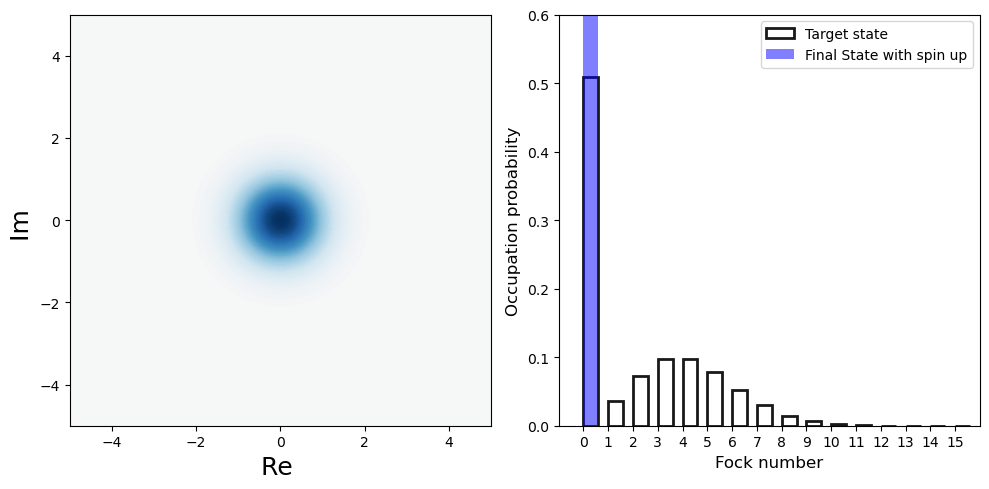

In [19]:
import matplotlib as mpl
def plot_bosonic(psi, target):
    rho_cavity = ptrace(psi, 0)
    rho_target = ptrace(target, 0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the bar charts for the coherent states and final state
    axes[1].bar(np.arange(0, N), np.real(rho_target.diag()),#np.abs(coherent(N, alpha).full().flatten())**2,
                width=0.6, color="white", alpha=0.9, align='edge',
                label='Target state ', edgecolor='black', linewidth=2)

    axes[1].bar(np.arange(0, N), np.real(rho_cavity.diag()),
                width=0.6, color="blue", alpha=0.5, align='edge',
                label='Final State with spin up')

    # Set the limits, labels, and ticks for the first subplot
    axes[1].set_ylim(0, 0.6)
    axes[1].set_xlim(-1, N)
    axes[1].set_xticks(np.arange(0, N))
    axes[1].set_xlabel('Fock number', fontsize=12)
    axes[1].set_ylabel('Occupation probability', fontsize=12)
    axes[1].legend()

    # Plot for the contour plot (Wigner function)
    xvec = np.linspace(-5,5,200)
    W = wigner(rho_cavity, xvec, xvec)
    wlim = abs(W).max()

    axes[0].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=plt.get_cmap('RdBu'))
    axes[0].set_xlabel(r'Re ', fontsize=18)
    axes[0].set_ylabel(r'Im ', fontsize=18)

    # Display the figure
    plt.tight_layout()
    plt.show()
plot_bosonic(resultState,target5)

In [20]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.delta_below(1e-5),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     6.03e-01    0.00e+00   6.03e-01        n/a        n/a    88
1     4.60e-01    1.15e-01   5.75e-01  -1.43e-01  -2.83e-02   183
2     3.10e-01    1.16e-01   4.27e-01  -1.50e-01  -3.34e-02   184
3     1.39e-01    1.39e-01   2.78e-01  -1.71e-01  -3.24e-02   184
4     1.02e-01    3.24e-02   1.34e-01  -3.75e-02  -5.08e-03   183
5     8.73e-02    1.24e-02   9.97e-02  -1.43e-02  -1.85e-03   681
6     7.39e-02    1.23e-02   8.62e-02  -1.34e-02  -1.09e-03   195
7     6.16e-02    7.15e-03   6.88e-02  -1.23e-02  -5.12e-03   183
8     4.97e-02    1.02e-02   6.00e-02  -1.19e-02  -1.67e-03   182
9     4.42e-02    5.20e-03   4.94e-02  -5.58e-03  -3.76e-04   194
10    3.05e-02    1.24e-02   4.29e-02  -1.36e-02  -1.23e-03   206
11    2.45e-02    5.44e-03   2.99e-02  -6.04e-03  -5.97e-04   198
12    2.19e-02    2.29e-03   2.42e-02  -2.63e-03  -3.35e-04   185
13    2.00e-02    1.66e-03   2.17e-02  -1.87e-03  -2.15e-04   186
14    1.85

In [ ]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2024-03-18 17:55:47
- Number of objectives: 1
- Number of iterations: 4
- Reason for termination: Reached convergence: Loss of monotonic convergence; error decrease < 0
- Ended at 2024-03-18 17:57:17 (0:01:30)

In [ ]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist,e_ops=[nc,nq])

In [ ]:
# psiResult = opt_dynamics.states[-1]
# fidelity(psiResult, initialState)

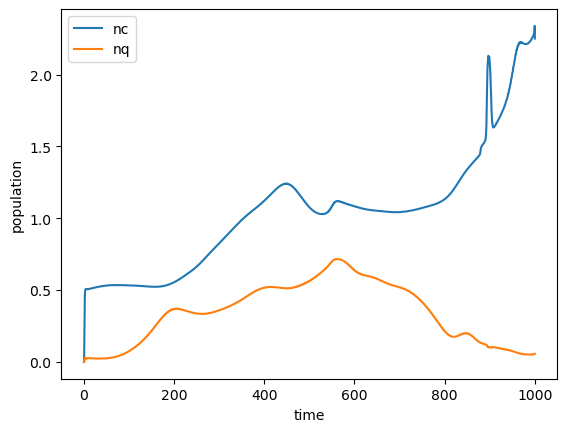

In [ ]:
plot_population(opt_dynamics)

In [ ]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr1,ax_ctr2, ax_ctr3,ax_dyn] = plt.subplots(nrows=4, figsize=(16, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[nc,nq]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr1.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_ctr2.plot(
            dynamics.times,
            controls[1],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_ctr3.plot(
            dynamics.times,
            controls[2],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )

        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('population')
    ax_ctr1.legend()
    ax_ctr1.set_xlabel('time')
    ax_ctr1.set_ylabel('cavity control amp (real)')
    ax_ctr2.legend()
    ax_ctr2.set_xlabel('time')
    ax_ctr2.set_ylabel('cavity control amp (imag)')
    ax_ctr3.legend()
    ax_ctr3.set_xlabel('time')
    ax_ctr3.set_ylabel('qubit control amp')
    plt.show(fig)

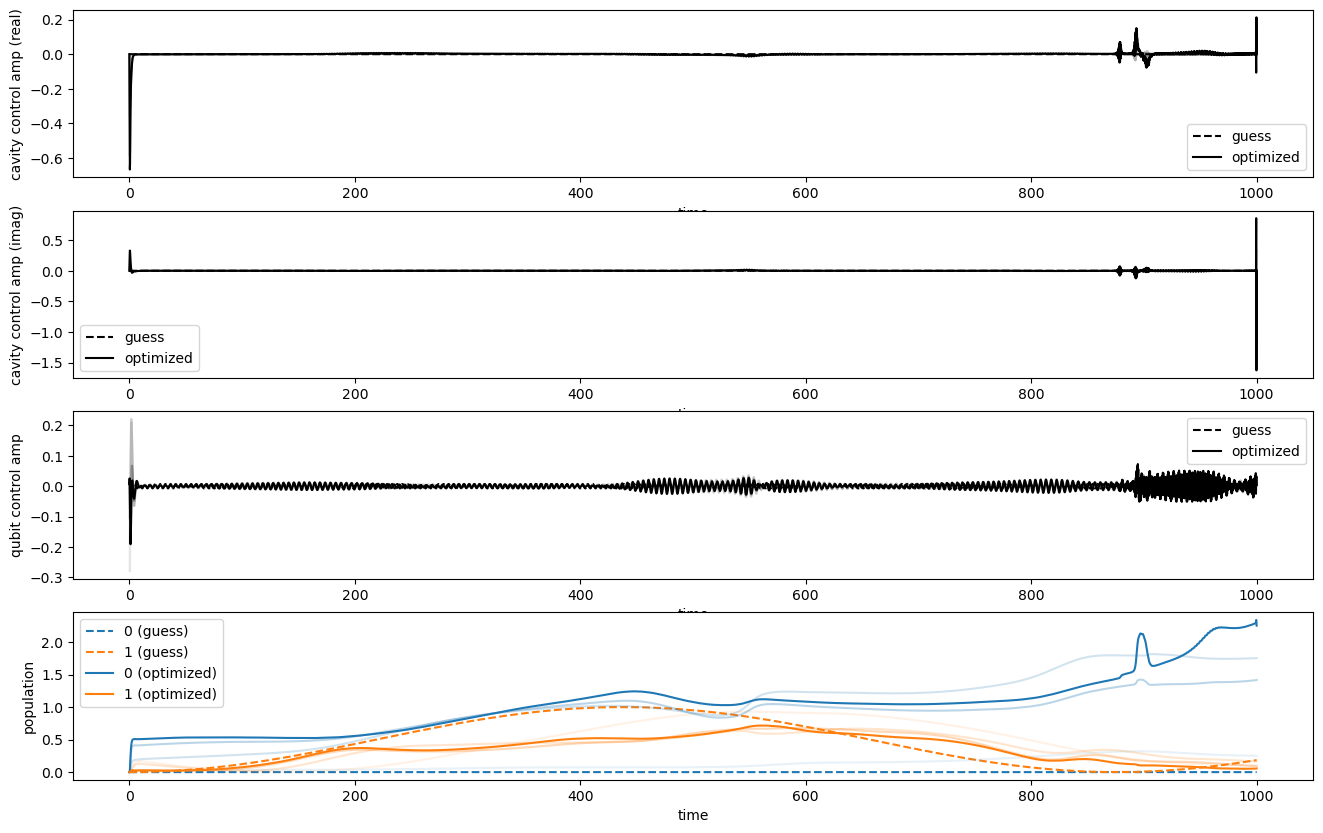

In [ ]:
plot_iterations(opt_result)

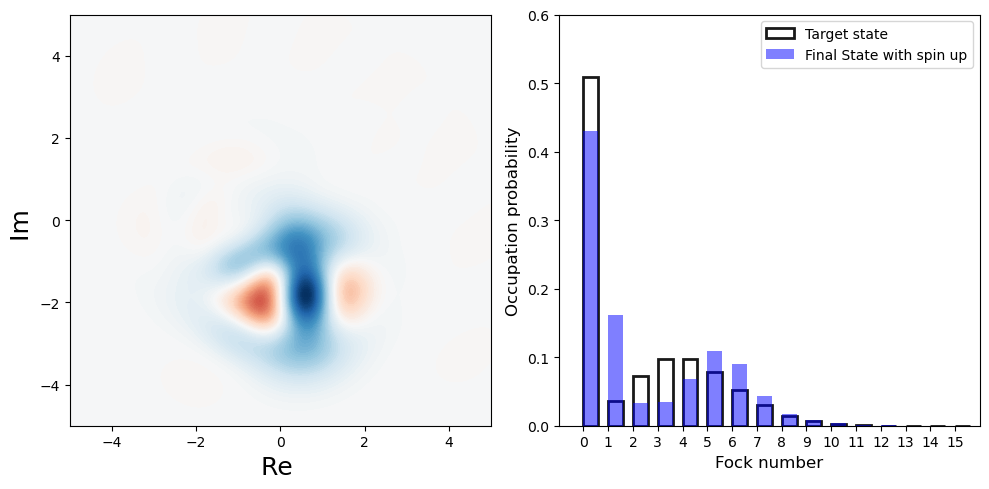

0.8699534881717739

In [ ]:
Result = opt_result.optimized_objectives[0].mesolve(
    tlist)
plot_bosonic(Result.states[-1],target5)
fidelity(Result.states[-1], target5)